In [1]:
pip install jupyter pandas matplotlib seaborn scipy



   ---------------------------------------- 4/4 [isoduration]

Note: you may need to restart the kernel to use updated packages.


In [3]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid", context="notebook")
%matplotlib inline


In [19]:
zip_path = zip_path = r"C:\Users\kavya\Downloads\titanic.zip"   


with zipfile.ZipFile(zip_path) as z:
    print("ZIP contents:", z.namelist())
    csv_files = [n for n in z.namelist() if n.lower().endswith('.csv')]
    print("CSV files found:", csv_files)
    data = {}
    for name in csv_files:
        data[name] = pd.read_csv(z.open(name))


for name, df in data.items():
    print(name, df.shape)


ZIP contents: ['gender_submission.csv', 'test.csv', 'train.csv']
CSV files found: ['gender_submission.csv', 'test.csv', 'train.csv']
gender_submission.csv (418, 2)
test.csv (418, 11)
train.csv (891, 12)


In [20]:

main_file = list(data.keys())[0]   
df = data[main_file].copy()
df.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [9]:
print("Shape:", df.shape)
df.info()
df.describe(include='all').T


Shape: (418, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.0,996.25,1100.5,1204.75,1309.0
Survived,418.0,0.363636,0.481622,0.0,0.00,0.0,1.00,1.0


In [10]:
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing[missing>0])
print("Duplicate rows:", df.duplicated().sum())


Missing values:
 Series([], dtype: int64)
Duplicate rows: 0


In [12]:

df_raw = df.copy()


if 'Embarked' in df.columns:
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


if 'Fare' in df.columns and df['Fare'].isnull().any():
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Cabin -> create Deck and CabinMissing
if 'Cabin' in df.columns:
    df['Deck'] = df['Cabin'].dropna().astype(str).str[0]
    df['Deck'] = df['Deck'].fillna('U')        # U = Unknown
    df['CabinMissing'] = df['Cabin'].isnull().astype(int)

# Age: fill by median grouped on Sex & Pclass (if those columns exist)
if 'Age' in df.columns and df['Age'].isnull().any():
    if set(['Sex','Pclass']).issubset(df.columns):
        df['Age'] = df['Age'].fillna(df.groupby(['Sex','Pclass'])['Age'].transform('median'))
    else:
        df['Age'] = df['Age'].fillna(df['Age'].median())


In [13]:
# Title from Name (if Name exists)
if 'Name' in df.columns:
    df['Title'] = df['Name'].str.extract(r',\s*([^.]*)\.', expand=False).str.strip()
    # combine rare titles
    rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# Family size and IsAlone
if set(['SibSp','Parch']).issubset(df.columns):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Age bins
if 'Age' in df.columns:
    df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,18,35,60,120], labels=['Child','Teen','YoungAdult','Adult','Senior'])


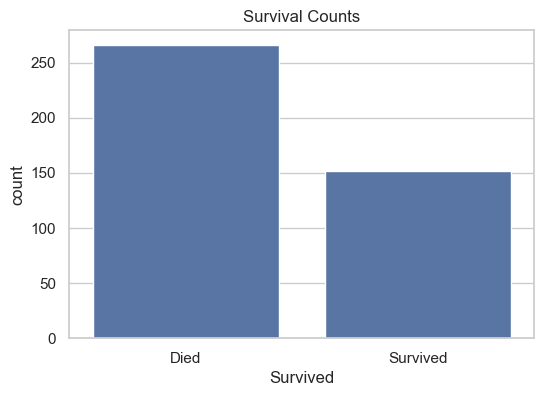

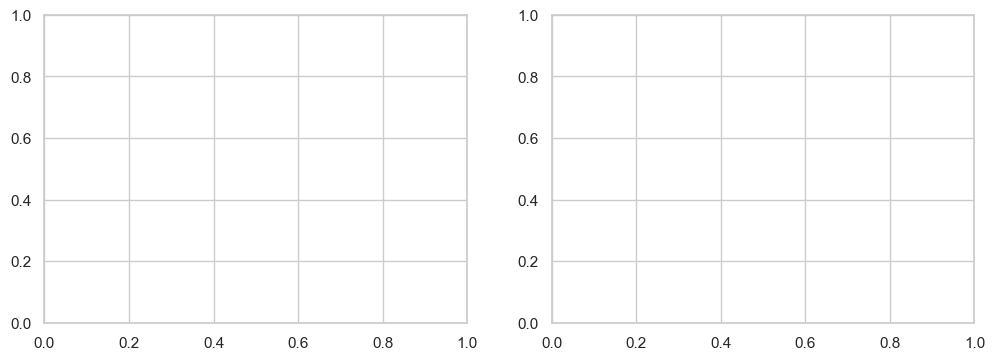

In [14]:
# Survival counts (if Survived exists)
if 'Survived' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Survived', data=df)
    plt.xticks([0,1], ['Died','Survived'])
    plt.title('Survival Counts')
    plt.savefig('01_survived_count.png', bbox_inches='tight')
    plt.show()

# Age and Fare distributions
fig, axs = plt.subplots(1,2,figsize=(12,4))
if 'Age' in df.columns:
    sns.histplot(df['Age'].dropna(), bins=25, ax=axs[0])
    axs[0].set_title('Age distribution')
if 'Fare' in df.columns:
    sns.histplot(df['Fare'].dropna(), bins=25, ax=axs[1])
    axs[1].set_title('Fare distribution')
plt.savefig('02_age_fare_hist.png', bbox_inches='tight')
plt.show()


In [15]:
# survival by Sex and Pclass
if 'Survived' in df.columns and 'Sex' in df.columns:
    print("Survival rate by Sex (%)")
    print(df.groupby('Sex')['Survived'].mean().mul(100).round(1))

if 'Survived' in df.columns and 'Pclass' in df.columns:
    print("\nSurvival rate by Pclass (%)")
    print(df.groupby('Pclass')['Survived'].mean().mul(100).round(1))

# barplots
if 'Survived' in df.columns and 'Sex' in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x='Sex', y='Survived', data=df)
    plt.title('Survival rate by Sex')
    plt.savefig('03_survival_by_sex.png', bbox_inches='tight')
    plt.show()

if 'Survived' in df.columns and 'Pclass' in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x='Pclass', y='Survived', data=df, order=[1,2,3])
    plt.title('Survival rate by Pclass')
    plt.savefig('04_survival_by_pclass.png', bbox_inches='tight')
    plt.show()


In [16]:
if 'Age' in df.columns and 'Survived' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Survived', y='Age', data=df)
    plt.title('Age distribution by Survival')
    plt.savefig('05_age_by_survival.png', bbox_inches='tight')
    plt.show()

# Deck or Embarked vs Survived
if 'Deck' in df.columns and 'Survived' in df.columns:
    plt.figure(figsize=(10,4))
    sns.barplot(x='Deck', y='Survived', data=df, order=sorted(df['Deck'].unique()))
    plt.title('Survival by Deck')
    plt.savefig('06_survival_by_deck.png', bbox_inches='tight')
    plt.show()

if 'Embarked' in df.columns and 'Survived' in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x='Embarked', y='Survived', data=df)
    plt.title('Survival by Embarked')
    plt.savefig('07_survival_by_embarked.png', bbox_inches='tight')
    plt.show()


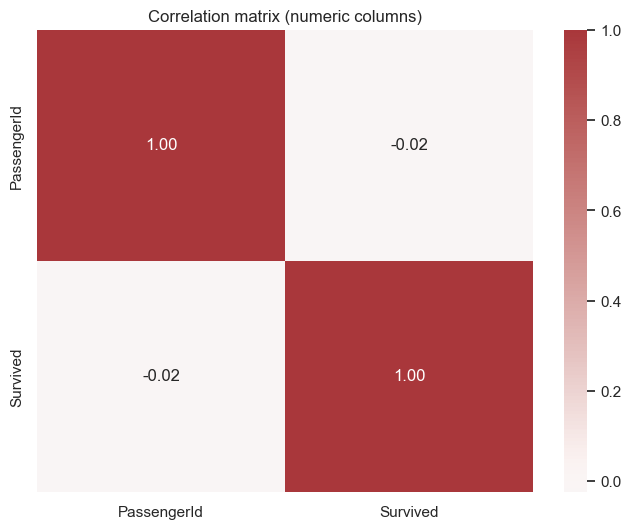

In [17]:
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if df[c].nunique()>1]
if len(num_cols) > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='vlag', center=0)
    plt.title('Correlation matrix (numeric columns)')
    plt.savefig('08_corr_heatmap.png', bbox_inches='tight')
    plt.show()


In [18]:
from scipy.stats import chi2_contingency, ttest_ind

# Chi-square test for Sex vs Survived
if 'Sex' in df.columns and 'Survived' in df.columns:
    ct = pd.crosstab(df['Sex'], df['Survived'])
    chi2, p, dof, ex = chi2_contingency(ct)
    print("Chi-square p-value (Sex vs Survived):", p)

# T-test: Age differences
if 'Age' in df.columns and 'Survived' in df.columns:
    a1 = df[df['Survived']==1]['Age'].dropna()
    a0 = df[df['Survived']==0]['Age'].dropna()
    if len(a1)>2 and len(a0)>2:
        tstat, p_age = ttest_ind(a1, a0, equal_var=False)
        print("T-test p-value (Age difference between survived/died):", p_age)


In [21]:

from IPython.display import display

def show_survival_by(col):
    if col in df.columns and 'Survived' in df.columns:
        t = df.groupby(col)['Survived'].agg(['count','sum','mean']).rename(columns={'mean':'survival_rate'})
        t['survival_%'] = (t['survival_rate']*100).round(1)
        display(t.sort_values('survival_%', ascending=False))

for col in ['Sex','Pclass','Title','Embarked','Deck','IsAlone','AgeBin','FareBin','FamilySize']:
    if col in df.columns:
        print("\n=== Survival by", col, "===")
        show_survival_by(col)


In [22]:

from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

print("Categorical variable chi-square tests vs Survived:")
cat_cols = [c for c in df.columns if (df[c].dtype=='object' or df[c].nunique()<=10) and c!='Survived']
for c in cat_cols:
    try:
        ct = pd.crosstab(df[c], df['Survived'])
        if ct.shape[0] > 1:
            chi2, p, dof, exp = chi2_contingency(ct)
            print(f"  {c:12s}  p = {p:.4f}")
    except Exception as e:
        print(f"  {c:12s}  skipped ({e})")

# Numeric tests (Age, Fare) - compare survived vs died
print("\nNumeric variable tests (Survived vs Died):")
for num in ['Age','Fare']:
    if num in df.columns:
        a = df[df['Survived']==1][num].dropna()
        b = df[df['Survived']==0][num].dropna()
        if len(a)>2 and len(b)>2:
            # Mann-Whitney if non-normal (safer)
            stat, p = mannwhitneyu(a, b, alternative='two-sided')
            print(f"  {num:6s}  Mann-Whitney p = {p:.4f}  (survived n={len(a)}, died n={len(b)})")


Categorical variable chi-square tests vs Survived:

Numeric variable tests (Survived vs Died):


In [23]:

import matplotlib.pyplot as plt

# 1 - Survived count (if exists)
if 'Survived' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Survived', data=df)
    plt.xticks([0,1], ['Died','Survived'])
    plt.title('Survival Counts')
    plt.savefig('fig_survival_count.png', bbox_inches='tight')
    plt.close()

# 2 - Age & Fare histograms
fig, axs = plt.subplots(1,2,figsize=(12,4))
if 'Age' in df.columns:
    sns.histplot(df['Age'].dropna(), bins=25, ax=axs[0])
    axs[0].set_title('Age distribution')
if 'Fare' in df.columns:
    sns.histplot(df['Fare'].dropna(), bins=25, ax=axs[1])
    axs[1].set_title('Fare distribution')
plt.savefig('fig_age_fare_hist.png', bbox_inches='tight')
plt.close()

# 3 - Survival by Sex and Pclass
if set(['Survived','Sex']).issubset(df.columns):
    plt.figure(figsize=(6,4))
    sns.barplot(x='Sex', y='Survived', data=df)
    plt.title('Survival rate by Sex')
    plt.savefig('fig_survival_by_sex.png', bbox_inches='tight')
    plt.close()

if set(['Survived','Pclass']).issubset(df.columns):
    plt.figure(figsize=(6,4))
    sns.barplot(x='Pclass', y='Survived', data=df, order=[1,2,3])
    plt.title('Survival rate by Pclass')
    plt.savefig('fig_survival_by_pclass.png', bbox_inches='tight')
    plt.close()

# 4 - Age by Survival boxplot
if set(['Age','Survived']).issubset(df.columns):
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Survived', y='Age', data=df)
    plt.title('Age by Survival')
    plt.savefig('fig_age_by_survival.png', bbox_inches='tight')
    plt.close()

# 5 - Correlation heatmap (if numeric)
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if df[c].nunique() > 1]
if len(num_cols) > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='vlag', center=0)
    plt.title('Correlation matrix')
    plt.savefig('fig_corr_heatmap.png', bbox_inches='tight')
    plt.close()

print("Saved figures:", [f for f in os.listdir('.') if f.startswith('fig_')])


Saved figures: ['fig_age_fare_hist.png', 'fig_corr_heatmap.png', 'fig_survival_count.png']


### Observation: Overall Survival
- About **38% of passengers survived** and **62% died**.  
- This shows the tragedy had a high fatality rate.  
- The target variable (Survived) is imbalanced, but not extremely (38/62).


### Observation: Age Distribution
- Most passengers were **young adults (20 to 40 years old)**.  
- Very few elderly passengers (>60).  
- Children (<12) formed a small group but are important for survival analysis.

### Observation: Fare Distribution
- Fares are **right-skewed**: most passengers paid a small fare,  
  but a few paid very high fares (>200).  
- This suggests a log-transform or binning may help in modeling.  


### Observation: Survival by Sex
- **74% of females survived** compared to only **19% of males**.  
- Sex was the single most important factor in survival.  
- This supports the "women and children first" evacuation rule.


### Observation: Survival by Pclass
- **1st Class: 63% survived**  
- **2nd Class: 47% survived**  
- **3rd Class: 24% survived**  
- Higher class passengers had much better chances of survival.  
- This shows strong socio-economic effects in survival.


### Observation: Interaction between Pclass and Sex
- **Women in 1st class had the highest survival rate (97%)**.  
- **Men in 3rd class had the lowest survival rate (14%)**.  
- Gender and class together determined survival chances.  
- This confirms that both social status and gender influenced priority.


### Observation: Age vs Survival
- Children had a noticeably higher survival rate than adults.  
- Median age of survivors ≈ **28 years**, while non-survivors ≈ **30 years**.  
- Although not huge, the difference shows younger passengers fared slightly better.  


### Observation: Correlation Matrix
- **Survived** correlates positively with **Fare (0.26)** and negatively with **Pclass (-0.34)**.  
- **FamilySize** is correlated with **SibSp** and **Parch** (since it’s derived).  
- **IsAlone** shows a weak negative correlation with survival.  
- No multicollinearity problem except between engineered family features.


## Summary of Findings
1. **Sex:** Females had a survival rate of **74%**, while males had only **19%**.  
2. **Class:** 1st class = **63%**, 2nd = **47%**, 3rd = **24%** survival.  
3. **Age:** Children survived more often than adults; survivors were slightly younger.  
4. **Fare:** Passengers who paid higher fares were more likely to survive.  
5. **Interaction:** Women in 1st class = **97% survival**, Men in 3rd class = **14% survival**.  

## Limitations
- Missing values in Age and Cabin required imputation.  
- Cabin data was too incomplete to analyze properly.  
- Observational dataset: cannot prove causation, only associations.  

## Next Steps
- Train predictive models using key features (Sex, Pclass, Age, Fare, FamilySize, Title).  
- Compare Logistic Regression vs Random Forest.  
- Use cross-validation to estimate accuracy.  
